# Example notebook for training a deep learning semantic segmentation model with labels generated by the "labeler" tool

In this notebook we use a GeoTIFF of high-resolution 4-chanel NAIP imagery from Redmond, WA and a corresponding GeoJSON consisting of 68 polygon labels created by a user with the "labeler" tool in this repository. The labels contain three classes: "building", "water", and "other" to simulate the type of labels that might be created by an annotation campaign. Specifically, this notebook shows how to: create label masks from a GeoJSON at _scene_ level, train a model using the imagery and mask with the [`torchgeo`](https://www.github.com/microsoft/torchgeo) library, and running inference with the final model to generate a dataset of predictions over the input imagery.

In [1]:
import subprocess

import fiona
import rasterio

## Step 0 - Download imagery and format labels

We first download NAIP imagery from the [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/), then warp the example labels (i.e. output from the labeler tool) to the same CRS as the NAIP imagery (this step is necessary as `gdal_rasterize` won't work otherwise).

In [2]:
!wget -P images/ "https://naipeuwest.blob.core.windows.net/naip/v002/wa/2019/wa_60cm_2019/47122/m_4712224_sw_10_060_20191011.tif"

--2022-10-14 03:58:19--  https://naipeuwest.blob.core.windows.net/naip/v002/wa/2019/wa_60cm_2019/47122/m_4712224_sw_10_060_20191011.tif
Resolving naipeuwest.blob.core.windows.net (naipeuwest.blob.core.windows.net)... 20.150.76.132
Connecting to naipeuwest.blob.core.windows.net (naipeuwest.blob.core.windows.net)|20.150.76.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 393372264 (375M) [application/octet-stream]
Saving to: ‘images/m_4712224_sw_10_060_20191011.tif’

m_4712224_sw_10_060 100%[===================>] 375.15M  5.88MB/s    in 55s     

2022-10-14 03:59:15 (6.82 MB/s) - ‘images/m_4712224_sw_10_060_20191011.tif’ saved [393372264/393372264]



In [3]:
!ogr2ogr -t_srs EPSG:26910 labels/example_labels_warped.geojson labels/example_labels.geojson 

In [4]:
input_image_fn = "images/m_4712224_sw_10_060_20191011.tif"
input_label_fn = "labels/example_labels_warped.geojson"

output_mask_fn = "masks/mask.tif"

## Step 1 - Create label masks

The first step is to create label masks. The "labeler" tool in this repo helps users create GeoJSONs containing annotations over satellite imagery (i.e. polygons where each polygon consists of a single label), however machine learning models frequently operate at a pixel level -- therefore the GeoJSON polygon representations must be converted to pixel-masks in order to be used in training. We use the [`gdal_rasterize`](https://gdal.org/programs/gdal_rasterize.html) command to accomplish this step.

In [5]:
unique_classes = set()
num_masks = 0
with fiona.open(input_label_fn) as f:
    for row in f:
        unique_classes.add(row["properties"]["class"])
        num_masks += 1

In [6]:
num_masks

68

In [7]:
class_names = sorted(list(unique_classes))

In [8]:
class_names

['building', 'other', 'water']

In [9]:
class_to_idx_map = {
    class_name: i + 1  # we add one to reserve class 0 as the nodata class
    for i, class_name in enumerate(class_names)
}

In [10]:
# get the bounds of the input image -- we use these to 
with rasterio.open(input_image_fn) as f:
    left, bottom, right, top = f.bounds
    width = f.width
    height = f.height
    print(f.crs)

EPSG:26910


In [11]:
# this creates a new raster -- each option is annotated below
command = [
    "gdal_rasterize",
    "-q",  # be quiet about it
    "-ot", "Byte",  # the output dtype of the raster should be uint8
    "-a_nodata", "0",  # the nodata value should be "0", this value will represent not-labeled in our training process
    "-init", "0",  # initialize all values to 0
    "-burn", str(class_to_idx_map[class_names[0]]),  # we will burn in the first class value to all polygons in the GeoJSON that match the first class label
    "-of", "GTiff",  # the output should be a GeoTIFF
    "-co", "TILED=YES",  # the output should be tiled, similar to COGs -- https://www.cogeo.org/ -- this is important for fast windowed reads
    "-co", "BLOCKXSIZE=512",  # this is important for fast windowed reads
    "-co", "BLOCKYSIZE=512",  # this is important for fast windowed reads
    "-co", "INTERLEAVE=PIXEL",  # this is important for fast windowed reads
    "-where", f"class='{class_names[0]}'",  # burn in values for polygons where the class label is the first class label
    "-te", str(left), str(bottom), str(right), str(top),  # the output GeoTIFF should cover the same bounds as the input image
    "-ts", str(width), str(height),  # the output GeoTIFF should have the same height and width as the input image
    "-co", "COMPRESS=LZW",  # compress it
    "-co", "PREDICTOR=2",  # compress it good
    "-co", "BIGTIFF=YES",  # just incase the image is bigger than 4GB
    input_label_fn,
    output_mask_fn,
]
assert subprocess.call(command) == 0

In [12]:
 # this burns in the class values for each other class in place
for i in range(1,len(class_names)):
    command = [
        "gdal_rasterize",
        "-q",
        "-b", "1",
        "-burn", str(class_to_idx_map[class_names[i]]),
        "-where", f"class='{class_names[i]}'",
        input_label_fn,
        output_mask_fn,
    ]
    assert subprocess.call(command) == 0

## Step 2 - Model training

Now that we have label masks, we can train a semantic segmentation model. To do this we will use the [`torchgeo`](https://www.github.com/microsoft/torchgeo) library which contains features for using geospatial data within the PyTorch ecosystem.

In [13]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, stack_samples
from torchgeo.samplers import RandomBatchGeoSampler, RandomGeoSampler
from torchgeo.trainers import SemanticSegmentationTask
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [14]:
def preprocess(sample):
    if "image" in sample:
        sample["image"] = (sample["image"] / 255.0).float()  # inputs are normalized to [0, 1]
    if "mask" in sample:
        sample["mask"] = sample["mask"].squeeze().long()
    del sample["bbox"]
    return sample

# we define a new pytorch_lightning DataModule to wrap the torchgeo datasets and create the necessary dataloaders
class SegmentationDataModule(pl.LightningDataModule):

    def __init__(
        self,
        image_fn_root,
        mask_fn_root,
        batch_size=64,
        patch_size=256,
        num_workers=6,
        train_batches_per_epoch=512,
        val_batches_per_epoch=32,
    ):
        super().__init__()

        self.image_fn_root = image_fn_root
        self.mask_fn_root = mask_fn_root
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.num_workers = num_workers
        self.train_batches_per_epoch = train_batches_per_epoch
        self.val_batches_per_epoch = val_batches_per_epoch

    def setup(self, stage=None):
        self.image_ds = RasterDataset(
            self.image_fn_root,
            transforms=preprocess
        )
        
        self.mask_ds = RasterDataset(
            self.mask_fn_root,
            transforms=preprocess
        )
        self.mask_ds.is_image = False

        self.ds = self.image_ds & self.mask_ds

    def train_dataloader(self):
        sampler = RandomBatchGeoSampler(
            self.ds, size=self.patch_size, batch_size=self.batch_size, length=self.train_batches_per_epoch * self.batch_size
        )

        return DataLoader(
            self.ds,
            batch_sampler=sampler,
            num_workers=self.num_workers,
            collate_fn=stack_samples
        )

    def val_dataloader(self):
        sampler = RandomBatchGeoSampler(
            self.ds, size=self.patch_size, batch_size=self.batch_size, length=self.val_batches_per_epoch * self.batch_size
        )

        return DataLoader(
            self.ds,
            batch_sampler=sampler,
            num_workers=self.num_workers,
            collate_fn=stack_samples
        )

In [15]:
# define some experiment parameters

experiment_dir = "results/"
experiment_name = "pre_model_1"

batch_size = 32
learning_rate = 0.0001
gpu_id = 0
device = torch.device(f"cuda:{gpu_id}")
num_dataloader_workers = 24

In [16]:
datamodule = SegmentationDataModule(
    "images/",
    "masks/",
    batch_size=batch_size,
    num_workers=num_dataloader_workers,
)

In [17]:
task = SemanticSegmentationTask(
    segmentation_model="unet",
    encoder_name="resnext50_32x4d",
    encoder_weights="imagenet",
    in_channels=4,
    num_classes=len(class_names) + 1,  # we include +1 to account for our 0 "not labeled" class
    loss="ce",
    ignore_index=0,  # we ignore the 0 class label because, by definition, we made this the "not labeled" class when creating the label masks
    learning_rate=learning_rate,
    learning_rate_schedule_patience=10
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=experiment_dir,
    save_top_k=1,
    save_last=True,
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=10,
)

tb_logger = TensorBoardLogger(
    save_dir="logs/",
    name=experiment_name
)

In [18]:
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=[tb_logger],
    default_root_dir=experiment_dir,
    min_epochs=10,
    max_epochs=20,
    accelerator='gpu',
    devices=[gpu_id]
)

_ = trainer.fit(model=task, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/pre_model_1
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Unet             | 32.0 M
1 | loss          | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
32.0 M    Trainable params
0         Non-trainable params
32.0 M    Total params
127.986   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/envs/hackathon/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/envs/hackathon/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Step 3 - Run inference with our trained model

Finally, now that we have a trained model, we can use it to run inference over the entire input to generate a dataset of predicted building locations.

In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
model = task.model
model = model.to(device)
model = model.eval()

In [30]:
with rasterio.open("images/m_4712224_sw_10_060_20191011.tif") as f:
    image = f.read()
    profile = f.profile
    
with rasterio.open("masks/mask.tif") as f:
     mask = f.read().squeeze()

In [31]:
x, y = 1, 2
step = 2048
# crop the image to the top left corner to make inference fit in the GPU (we could use a sliding window if we wanted to be more serious)
image = image[:, y*step:(y+1)*step, x*step:(x+1)*step]
mask = mask[y*step:(y+1)*step, x*step:(x+1)*step]

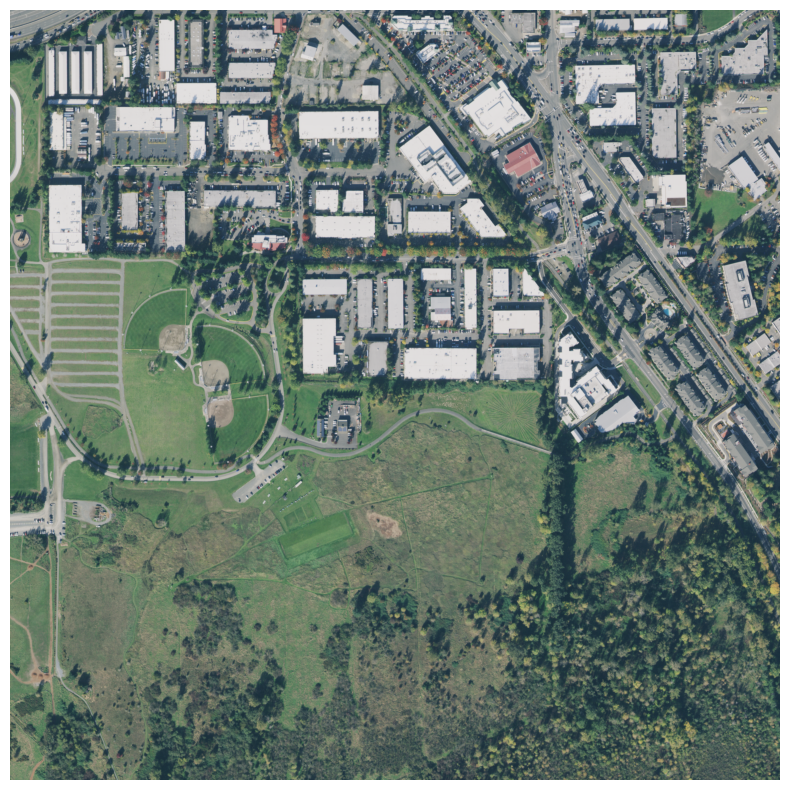

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(np.rollaxis(image[:3, :,:], 0, 3))
plt.axis("off")
plt.show()
plt.close()

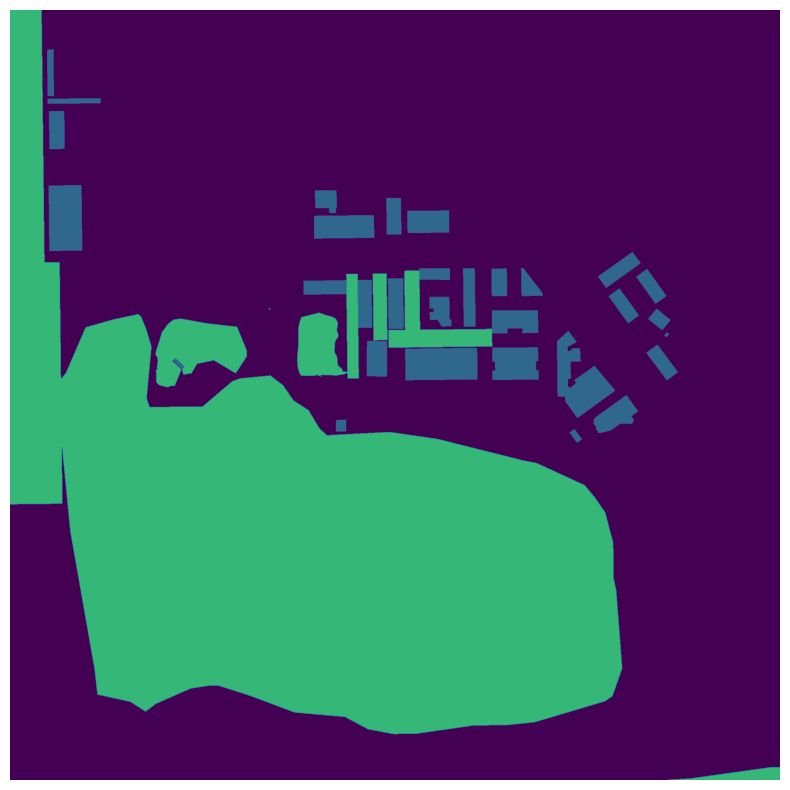

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(mask, vmin=0, vmax=3)
plt.axis("off")
plt.show()
plt.close()

In [34]:
image = (torch.from_numpy(image).unsqueeze(0) / 255.0).float()

In [35]:
image = image.to(device)

In [36]:
with torch.inference_mode():
    predictions = model(image).argmax(axis=1).cpu().numpy().squeeze()

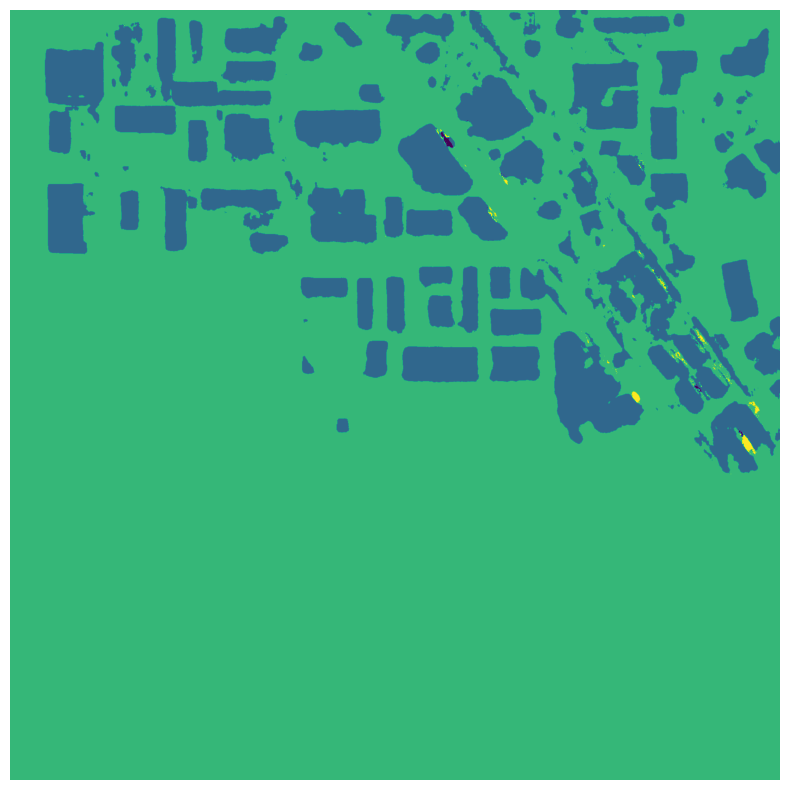

In [37]:
plt.figure(figsize=(10,10))
plt.imshow(predictions, vmin=0, vmax=3)
plt.axis("off")
plt.show()
plt.close()

In [38]:
import rasterio.transform

In [46]:
newx, newy = profile["transform"] * (x*step, y*step)

In [47]:
# we write out the predictions to a GeoTIFF so that they can be further visualized and analyzed with GIS tools
profile["nodata"] = None
profile["count"] = 1
profile["height"] = step
profile["width"] = step
profile["transform"] = rasterio.transform.from_origin(newx, newy, 0.6, 0.6)  # adjust the transform to take into account that we aren't running inference from the top left
with rasterio.open("predictions.tif", "w", **profile) as f:
    f.write(predictions.astype(np.uint8), 1)